In [1]:
import numpy as np
import pylab as plt
import math
from sympy.physics.wigner import gaunt
from scipy.integrate import odeint
from scipy import integrate
%matplotlib inline

In [2]:
BohrRad=0.529177e-10
Dalton=1.66053906892e-27
me=9.1093837e-31
mH=1.00784*Dalton
mT=3.01604928178*Dalton
GGHz2H = 1.519829846e-7 #giga hertz to hartrees conversion factor 
#at this point we start to use purely atomic units because we are pretensious
muoveH=mH/(2*me) #mass is unitless in atomic units because we let me = 1 H stands for Hydrogen 
muoveT=mT/(2*me) #T stands for tritium

l = 0 #this is explicitly required for properly defining our in state at infinity
l_prime = 2 #all allowed transitions require even l transitions, these are confirmed with Winger 3J symbols from the spherical nature
#of the distored wave Born approximation

In [3]:
#Getting the hyperfine and zeeman level energy contributions to the total energy
HyperFine=21e-2
c=3e8
delW=c/HyperFine

gI=5.585
ge=2
gL=1
gS=2
mue=9.27e-24
mN=1e9

B_values=np.linspace(1e-5,.1,20)

def PlotHyperfineLevels(pm,mF,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02):
    h=6.6e-34
    S=0.5
    mue=9.27e-24
    me=5.11e5
    muN=mue*me/(1e9*mN)

    gJ=gL*(J*(J+1)+L*(L+1)-S*(S+1))/(2*J*(J+1))  +ge*(J*(J+1)-L*(L+1)+S*(S+1))/(2*J*(J+1))
    
    x=B*(gJ*mue-gI*muN)/(h *delW)
    Term1=-h*delW/(2*(2*I+1))*np.ones_like(B)
    Term2=muN*gI*mF*B
    if(abs(mF)==abs(I+0.5)):
        sgn=mF/(I+0.5)
        Term3=h*delW/2*(1+sgn*x)
    else:    
        Term3=pm*h*delW/2*np.sqrt(1+2*mF*x/(I+0.5)+x**2)

    delE=1e-9*(Term1+Term2+Term3)/h
    
    return delE
#it is important to note that this code uses B field in tesla and the representing hyperfine energies are in units of gigahertz

In [4]:
#Defining the schodinger equation such that the hyperfine and zeeman contributions get absorbed into our p values 
def Potential(R): #Silvera Potential Energy Units are in Hartrees
    x=R*BohrRad/4.16e-10
    D=1.28
    KToH=315775
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46/KToH*(4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)
    
def Triplet(R):
    return np.exp(0.09678-1.10173*R-0.03945*R**2)+np.exp(-(10.04/R-1)**2)*(-6.5/R**6-124/R**8-3285/R**10)
    
def ddxH1(y,rho, l, p): #SE for Hydrogen now represented as two first order ODEs
    u=y[0]
    v=y[1]
    dudx=v
    dvdx=(-p**2+2*muoveH*Potential(rho) + l*(l+1)/(rho**2))*u
    return [dudx,dvdx]
    
def ddxT1(y,rho, l, p):
    u=y[0]
    v=y[1]
    dudx=v
    dvdx=(-p**2+2*muoveT*Potential(rho) + l*(l+1)/(rho**2))*u
    return [dudx,dvdx]

def ddxH2(y,rho, l, p): #SE for Hydrogen now represented as two first order ODEs
    u=y[0]
    v=y[1]
    dudx=v
    dvdx=(-p**2+2*muoveH*Triplet(rho) + l*(l+1)/(rho**2))*u
    return [dudx,dvdx]
    
def ddxT2(y,rho, l, p):
    u=y[0]
    v=y[1]
    dudx=v
    dvdx=(-p**2+2*muoveT*Triplet(rho) + l*(l+1)/(rho**2))*u
    return [dudx,dvdx]

In [5]:
#our integral has us looking at a box of length L, with well defined initial boundary conditions
#we want reasonable momentum at the sub millikelvin scale therefore via E = kbT = p^2 / 2mu we chose our momentum value
init = [1e-1, 1]  
L=100
rhos = np.linspace(1e-1, L, 10*int(L)) 

kb = 3.166811563e-6 # units Hartrees per Kelvin
T = 1e-3 # useful temperature scale
pT = (2*muoveT*kb*T)**.5 
pH = (2*muoveH*kb*T)**.5

In [6]:
GHaa1_Elements=[]
GTaa1_Elements=[]
GHac1_Elements=[]
GTac1_Elements=[]
GHad1_Elements=[]
GTad1_Elements=[]
for B in B_values:
    epsa = GGHz2H*PlotHyperfineLevels(0,0,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) #Following Stoofs notation these 
    epsb = GGHz2H*PlotHyperfineLevels(1,-1,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) # are the channel specific energies
    epsc = GGHz2H*PlotHyperfineLevels(1,0,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) # in order of lowest energy to highest
    epsd = GGHz2H*PlotHyperfineLevels(1,1,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) #we need to convert the hyperfine energies
    for i in [0,1,2]:
        epsalpha = epsd #Following Stoofs notation again, alpha and beta are the associated in states and the primes from here on will
        epsbeta = epsd #be used to designate the time reversed out states post interaction. We select specific ones that Stoof claims to be 
        epsalpha_prime = epsa # the dominating terms in the important inelastic trap loss rates

        if i == 0:
            epsbeta_prime = epsa
        elif i == 1:
            epsbeta_prime = epsc
        elif i == 2:
            epsbeta_prime = epsd

        Hp_prime = (2*muoveH*(epsalpha + epsbeta - epsalpha_prime - epsbeta_prime + pH**2/(2*muoveH)))**.5 #under energy conservation this is how
        Tp_prime = (2*muoveT*(epsalpha + epsbeta - epsalpha_prime - epsbeta_prime + pT**2/(2*muoveT)))**.5 #we define the associated outward momentum 

    
        Hsoln_l = odeint(ddxH1, init, rhos, args=(l, pH), rtol=1e-6) #This is the radial solution divided by r associated with the Triplet Potential
        Tsoln_l = odeint(ddxT1, init, rhos, args=(l, pT), rtol=1e-6) #because at low rho this is the dominating potential and we will treat the 
    #dipolar interactions as a pertubation to this well understood wave states as confirmed by our previous cross section calculation
    
        Hsoln_lprime = odeint(ddxH1, init, rhos, args=(l_prime, Hp_prime), rtol=1e-6) #The outward going state same potential scattering but 
        Tsoln_lprime = odeint(ddxT1, init, rhos, args=(l_prime, Tp_prime), rtol=1e-6) #now with new internal states and therefor new 
    #total angular momentum
        
        def HNormalization1(r): #the inwards traveling wave is that of a phase shifted sine wave and therefore applying the well understood
            ul = np.interp(r, rhos, Hsoln_l[:,0]) #pythagorean theorem for sines and cosines we can normalize to 1 as follows
            dul_dx = np.interp(r, rhos, Hsoln_l[:,1])
            return (ul**2 + 1/pH**2 * dul_dx**2)**.5
    
        def TNormalization1(r):
            ul = np.interp(r, rhos, Tsoln_l[:,0])
            dul_dx = np.interp(r, rhos, Tsoln_l[:,1])
            return (ul**2 + 1/pT**2 * dul_dx**2)**.5
    
        def HNormalization2(r): #same normalization as above but now for the outward traveling wave
            ul_prime = np.interp(r, rhos, Hsoln_lprime[:,0])
            dul_dx_prime = np.interp(r, rhos, Hsoln_lprime[:,1])
            return (ul_prime**2 + 1/Hp_prime**2 * dul_dx_prime**2)**.5

        def TNormalization2(r):
            ul_prime = np.interp(r, rhos, Tsoln_lprime[:,0])
            dul_dx_prime = np.interp(r, rhos, Tsoln_lprime[:,1])
            return (ul_prime**2 + 1/Tp_prime**2 * dul_dx_prime**2)**.5
        
        def HRadial_Dipolar_Potential_Integrand(r): #This is the interesting physics bit of the distorted wave approximation
            ul = np.interp(r, rhos, Hsoln_l[:, 0]) #By having our dipolar potential sandwiched between our two normalized wave states we can 
            ulprime = np.interp(r, rhos, Hsoln_lprime[:, 0]) #now understand what this "perturbation" is doing
            return (4*np.pi/5)**.5*(1/4*np.pi)/HNormalization1(L)/HNormalization2(L)*ul*np.conj(ulprime) / r**3

        def TRadial_Dipolar_Potential_Integrand(r):
            ul = np.interp(r, rhos, Tsoln_l[:, 0])
            ulprime = np.interp(r, rhos, Tsoln_lprime[:, 0])
            return (4*np.pi/5)**.5*(1/4*np.pi)/TNormalization1(L)/TNormalization2(L)*ul*np.conj(ulprime) / r**3
            
        HDipolar_Term = integrate.quad(HRadial_Dipolar_Potential_Integrand, 1e-5, rhos[-1])[0]
        TDipolar_Term = integrate.quad(TRadial_Dipolar_Potential_Integrand, 1e-5, rhos[-1])[0]

        GH_Element =4*np.pi**3*muoveH*Hp_prime*(HDipolar_Term)**2/(pH*Hp_prime)**2#See Stoof for this definition of the trap loss rates
        GT_Element =4*np.pi**3*muoveT*Tp_prime*(TDipolar_Term)**2/(pT*Tp_prime)**2

        if i == 0:
            GHaa1_Elements.append(GH_Element)
            GTaa1_Elements.append(GT_Element)
        elif i == 1:
            GHac1_Elements.append(GH_Element)
            GTac1_Elements.append(GT_Element)
        elif i == 2:
            GHad1_Elements.append(GH_Element)
            GTad1_Elements.append(GT_Element)
GHaa1_Elements = np.array(GHaa1_Elements)
GTaa1_Elements = np.array(GTaa1_Elements)
GHac1_Elements = np.array(GHac1_Elements)
GTac1_Elements = np.array(GTac1_Elements)
GHad1_Elements = np.array(GHad1_Elements)
GTad1_Elements = np.array(GTad1_Elements)


In [7]:
GHaa2_Elements=[]
GTaa2_Elements=[]
GHac2_Elements=[]
GTac2_Elements=[]
GHad2_Elements=[]
GTad2_Elements=[]
for B in B_values:
    epsa = GGHz2H*PlotHyperfineLevels(0,0,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) #Following Stoofs notation these 
    epsb = GGHz2H*PlotHyperfineLevels(1,-1,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) # are the channel specific energies
    epsc = GGHz2H*PlotHyperfineLevels(1,0,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) # in order of lowest energy to highest
    epsd = GGHz2H*PlotHyperfineLevels(1,1,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) #we need to convert the hyperfine energies
    for j in [0,1,2]:
        epsalpha = epsd #Following Stoofs notation again, alpha and beta are the associated in states and the primes from here on will
        epsbeta = epsd #be used to designate the time reversed out states post interaction. We select specific ones that Stoof claims to be 
        epsalpha_prime = epsa # the dominating terms in the important inelastic trap loss rates

        if j == 0:
            epsbeta_prime = epsa
        elif j == 1:
            epsbeta_prime = epsc
        elif j == 2:
            epsbeta_prime = epsd

        Hp_prime = (2*muoveH*(epsalpha + epsbeta - epsalpha_prime - epsbeta_prime + pH**2/(2*muoveH)))**.5 #under energy conservation this is how
        Tp_prime = (2*muoveT*(epsalpha + epsbeta - epsalpha_prime - epsbeta_prime + pT**2/(2*muoveT)))**.5 #we define the associated outward momentum 

        Hsoln_l = odeint(ddxH2, init, rhos, args=(l, pH), rtol=1e-6) #This is the radial solution divided by r associated with the Triplet Potential
        Tsoln_l = odeint(ddxT2, init, rhos, args=(l, pT), rtol=1e-6) #because at low rho this is the dominating potential and we will treat the 
    #dipolar interactions as a pertubation to this well understood wave states as confirmed by our previous cross section calculation
    
        Hsoln_lprime = odeint(ddxH2, init, rhos, args=(l_prime, Hp_prime), rtol=1e-6) #The outward going state same potential scattering but 
        Tsoln_lprime = odeint(ddxT2, init, rhos, args=(l_prime, Tp_prime), rtol=1e-6) #now with new internal states and therefor new 
    #total angular momentum
        
        def HNormalization1(r): #the inwards traveling wave is that of a phase shifted sine wave and therefore applying the well understood
            ul = np.interp(r, rhos, Hsoln_l[:,0]) #pythagorean theorem for sines and cosines we can normalize to 1 as follows
            dul_dx = np.interp(r, rhos, Hsoln_l[:,1])
            return (ul**2 + 1/pH**2 * dul_dx**2)**.5
    
        def TNormalization1(r):
            ul = np.interp(r, rhos, Tsoln_l[:,0])
            dul_dx = np.interp(r, rhos, Tsoln_l[:,1])
            return (ul**2 + 1/pT**2 * dul_dx**2)**.5

        def HNormalization2(r): #same normalization as above but now for the outward traveling wave
            ul_prime = np.interp(r, rhos, Hsoln_lprime[:,0])
            dul_dx_prime = np.interp(r, rhos, Hsoln_lprime[:,1])
            return (ul_prime**2 + 1/Hp_prime**2 * dul_dx_prime**2)**.5

        def TNormalization2(r):
            ul_prime = np.interp(r, rhos, Tsoln_lprime[:,0])
            dul_dx_prime = np.interp(r, rhos, Tsoln_lprime[:,1])
            return (ul_prime**2 + 1/Tp_prime**2 * dul_dx_prime**2)**.5
        
        def HRadial_Dipolar_Potential_Integrand(r): #This is the interesting physics bit of the distorted wave approximation
            ul = np.interp(r, rhos, Hsoln_l[:, 0]) #By having our dipolar potential sandwiched between our two normalized wave states we can 
            ulprime = np.interp(r, rhos, Hsoln_lprime[:, 0]) #now understand what this "perturbation" is doing
            return (4*np.pi/5)**.5*(1/4*np.pi)/HNormalization1(L)/HNormalization2(L)*ul*np.conj(ulprime) / r**3

        def TRadial_Dipolar_Potential_Integrand(r):
            ul = np.interp(r, rhos, Tsoln_l[:, 0])
            ulprime = np.interp(r, rhos, Tsoln_lprime[:, 0])
            return (4*np.pi/5)**.5*(1/4*np.pi)/TNormalization1(L)/TNormalization2(L)*ul*np.conj(ulprime) / r**3
        
        HDipolar_Term = integrate.quad(HRadial_Dipolar_Potential_Integrand, 1e-5, rhos[-1])[0]
        TDipolar_Term = integrate.quad(TRadial_Dipolar_Potential_Integrand, 1e-5, rhos[-1])[0]

        GH_Element =4*np.pi**3*muoveH*Hp_prime*(HDipolar_Term)**2/(pH*Hp_prime)**2#See Stoof for this definition of the trap loss rates
        GT_Element =4*np.pi**3*muoveT*Tp_prime*(TDipolar_Term)**2/(pT*Tp_prime)**2
        if j == 0:
            GHaa2_Elements.append(GH_Element)#we are inside a specific B value and need to add it to our array that will be plotted
            GTaa2_Elements.append(GT_Element)
        elif j == 1:
            GHac2_Elements.append(GH_Element)#we are inside a specific B value and need to add it to our array that will be plotted
            GTac2_Elements.append(GT_Element)
        elif j == 2:
            GHad2_Elements.append(GH_Element)#we are inside a specific B value and need to add it to our array that will be plotted
            GTad2_Elements.append(GT_Element)  
GHaa2_Elements = np.array(GHaa2_Elements)
GTaa2_Elements = np.array(GTaa2_Elements)
GHac2_Elements = np.array(GHac2_Elements)
GTac2_Elements = np.array(GTac2_Elements)
GHad2_Elements = np.array(GHad2_Elements)
GTad2_Elements = np.array(GTad2_Elements)


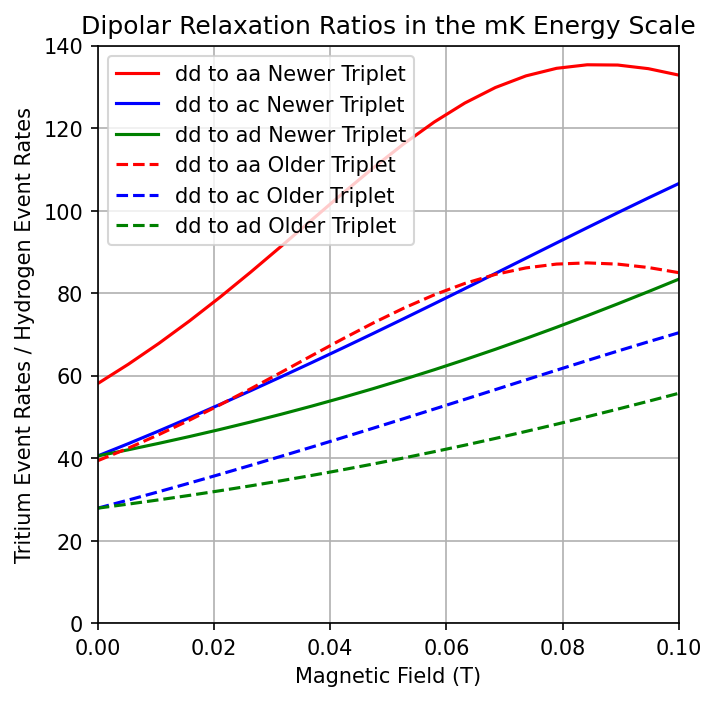

In [8]:
plt.figure(figsize=(5, 5),dpi=150)
plt.plot(B_values,GTaa1_Elements/GHaa1_Elements, label="dd to aa Newer Triplet",color ="red")
plt.plot(B_values,GTac1_Elements/GHac1_Elements,label="dd to ac Newer Triplet",color ="blue")
plt.plot(B_values,GTad1_Elements/GHad1_Elements,label="dd to ad Newer Triplet",color ="green")
plt.plot(B_values,GTaa2_Elements/GHaa2_Elements, label="dd to aa Older Triplet",linestyle='--',color ="red")
plt.plot(B_values,GTac2_Elements/GHac2_Elements,label="dd to ac Older Triplet",linestyle='--',color ="blue")
plt.plot(B_values,GTad2_Elements/GHad2_Elements,label="dd to ad Older Triplet",linestyle='--',color ="green")
plt.xlabel("Magnetic Field (T)")
plt.xlim(0,.1)
plt.ylabel("Tritium Event Rates / Hydrogen Event Rates")
plt.ylim(0,140)
plt.title("Dipolar Relaxation Ratios in the mK Energy Scale")
plt.grid(True)
plt.legend()
plt.show()